In [29]:
# Import required libraries for data manipulation and analysis
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

In [30]:
#Import required sklearn functions
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.inspection import permutation_importance
from collections import defaultdict

In [31]:
#Import sklearn classifiers
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [32]:
#Import library to oversample 
from imblearn.over_sampling import RandomOverSampler

In [33]:
#Import RDKit and Mordred libraries
from rdkit import Chem
from rdkit.Chem import Draw
from mordred import Calculator, descriptors

In [34]:
#Allows figures to be visualized in jupyter notebook
%matplotlib inline

In [35]:
# Sets Pandas Display to Monitor Code
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

In [36]:
# Create Mordred Calculator
calc = Calculator(descriptors, ignore_3D=True)

In [37]:
# Read Training/Test data input File
data = pd.read_csv('BorylationTrainingTest.csv')

In [38]:
# Assigns Reactants Mordred Info
reactants = data['Substrate']

reactants_mol_list = []
for inChi_reactants in reactants:
  reactants_mol = Chem.MolFromInchi(inChi_reactants)
  reactants_mol_list.append(reactants_mol)

reactants_img = Draw.MolsToGridImage(reactants_mol_list, molsPerRow=4)

/home/sweav003/envs/CHB/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


In [39]:
# Puts reactants into Pandas Type
reactant_data = []
reactant_data = calc.pandas(reactants_mol_list)
reactant_data.info()

100%|██████████| 642/642 [01:23<00:00,  7.72it/s]


<class 'mordred._base.pandas_module.MordredDataFrame'>
RangeIndex: 642 entries, 0 to 641
Columns: 1613 entries, ABC to mZagreb2
dtypes: bool(2), float64(900), int64(324), object(387)
memory usage: 7.9+ MB


In [40]:
#Joins Mordred parameters with experimental, atomic charges, and JChem for Excel parameters
add_reactants = pd.concat((data, reactant_data), axis=1)

In [41]:
#Force any non-numeric entries as NaN and replace them with 0
final_data = add_reactants.apply(pd.to_numeric, errors='coerce')
final_data.fillna(0, inplace=True)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Columns: 1682 entries, Substrate to mZagreb2
dtypes: bool(2), float64(1329), int64(351)
memory usage: 8.2 MB


In [42]:
# Seperate dataset as response variable (Product Ratio) and feature variables
#Note: Product Ratio is described as "0" for non-borylating sites and "1" for borylating sites
X = final_data.drop('Product_Ratio' , axis = 1)
y = final_data['Product_Ratio']

In [43]:
#Remove any features that have zero variance, i.e. remain the same number for every entry
sel = VarianceThreshold()
_ = sel.fit(X)
mask = sel.get_support()
X = X.loc[:,mask]

In [44]:
#Remove any features that are greater than 95% correlated
corr_matrix = X.corr()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

Final = X.drop(to_drop, axis = 1)
corr_matrix=Final.corr()

plt.figure(figsize = (10, 10),dpi=1000)
sns.heatmap(
    corr_matrix, 
    annot =False,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
   )

plt.show()

In [45]:
# Specifys Random Forest and the Number of Trees, SelectFromModel will
# select features which are most important
feature_names = [f"feature {i}" for i in range(Final.shape[1])]
forest = RandomForestClassifier(random_state=42)
forest.fit(Final, y)

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

threshold = np.sort(importances)[-100] 
sel = SelectFromModel(RandomForestClassifier(n_estimators = 800, max_depth=30),threshold=threshold)
sel.fit(Final, y)

# Select the final features set 
sel.get_support()
selected_feat= Final.columns[(sel.get_support())]

# Prints the names of the final selected features
print(selected_feat)

final = Final[selected_feat]

Index(['Hirshfeld Heavy Atom Charge', 'CM5 Charge', 'Hirshfeld Carbon Charge',
       'Hirshfeld Hydrogen Charge', 'ESP Heavy Atom Charge',
       'ESP Carbon Charge', 'ESP Hydrogen Charge', 'NPA Carbon Charge',
       'NPA Hydrogen Charge', 'MBS Carbon Charge', 'MBS Hydrogen Charge',
       'Mulliken Heavy Charge', 'Mulliken Carbon Charge',
       'Mulliken Hydrogen Charge', 'Steric Effect Index',
       'Atomic_Polarizability', 'Distance Degree', 'Dreiding Energy',
       'Eccentricity', 'Max Projection Area', 'Max Projection Radius', 'MaxZ',
       'Sigma Electronegativity', 'ATS0p', 'AATS0d', 'AATS0i', 'AATS5i',
       'ATSC1d', 'AATSC2dv', 'AATSC1d', 'AATSC2d', 'AATSC1pe', 'GATS2pe',
       'BCUTd-1h', 'BCUTZ-1l', 'BCUTse-1l', 'Xch-7dv', 'ETA_shape_y', 'IC3',
       'CIC0'],
      dtype='object')


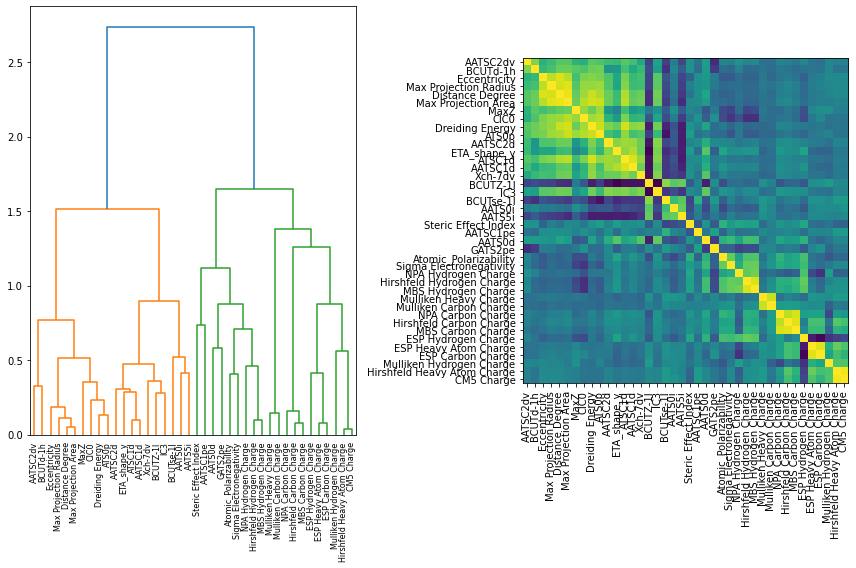

In [46]:
#Create dendrogram and spearman matrix used for removing multicollinear features
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

corr = spearmanr(final).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

labels = selected_feat

distance_matrix = 1 - np.abs(corr)

dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=labels, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

In [47]:
#Test different settings of dendrogram threhold for the highest accuracy
Results_df = pd.DataFrame(columns = ["threshold", "True Neg","False Pos","False Neg","True Pos", 'acc', 'precision 0',
                                   'precision 1','recall 0', 'recall 1', 'F1 0', 'F1 1'])
for x in [0.25, 0.25, 0.25, 0.25, 0.25, 
          0.3,  0.3, 0.3,  0.3, 0.3,  
          0.35,  0.35, 0.35,  0.35, 0.35,  
         0.4, 0.4, 0.4, 0.4, 0.4, 
          0.45, 0.45, 0.45, 0.45, 0.45,  
         0.5, 0.5, 0.5, 0.5, 0.5]:    
        #Perform training/test set split
        X_train, X_test, y_train, y_test = train_test_split(final, y, test_size=0.20, random_state=31)

        #Apply over-sampling to dataset
        ros = RandomOverSampler(random_state=10)
        X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

        # Applies random forest classifier to the dataset
        rfc = RandomForestClassifier(n_estimators=800,max_depth=9)
        rfc.fit(X_resampled, y_resampled)

        trained_result = permutation_importance(
            rfc, X_resampled, y_resampled, n_repeats=5, random_state=16, n_jobs=5)

        trained_forest_importances = pd.Series(trained_result.importances_mean, 
                                          index= final.columns.values)
    
        trained_cluster_ids = hierarchy.fcluster(dist_linkage, x, criterion="distance")
        trained_cluster_id_to_feature_ids = defaultdict(list)

        for idx, trained_cluster_id in enumerate(trained_cluster_ids):
            trained_cluster_id_to_feature_ids[trained_cluster_id].append(idx)
    
        trained_selected_features = [v[0] for v in trained_cluster_id_to_feature_ids.values()]
        final_selected_features = X_resampled.columns[trained_selected_features]

        X_train = X_resampled[final_selected_features]
        X_test = X_test[final_selected_features]

        rfc.fit(X_train, y_resampled)
        correlated_trained_result = permutation_importance(
            rfc, X_train, y_resampled, n_repeats=5, random_state=16, n_jobs=5)

        pred_rfc = rfc.predict(X_test)
    
        #Calculate confusion matrix
        cf_matrix = confusion_matrix(y_test, pred_rfc)
        cf_matrix = np.reshape(cf_matrix,(1,4)) 

        #Calculate sklearn classification metrics
        acc = accuracy_score(y_test, pred_rfc)
        prec = precision_score(y_test, pred_rfc, average=None)
        recall = recall_score(y_test, pred_rfc, average=None)
        F1 = f1_score(y_test, pred_rfc, average=None)
        comb = np.concatenate((x, cf_matrix, acc, prec, recall, F1), axis=None)
        comb = [comb]
        Results_df = Results_df.append(pd.DataFrame(comb, columns=Results_df.columns), ignore_index=True) 

#Print the classification evaluations for model
print(Results_df)    


    threshold  True Neg  False Pos  False Neg  True Pos       acc  \
0        0.25      98.0        9.0       11.0      11.0  0.844961   
1        0.25      98.0        9.0       12.0      10.0  0.837209   
2        0.25      98.0        9.0       11.0      11.0  0.844961   
3        0.25      98.0        9.0       12.0      10.0  0.837209   
4        0.25      96.0       11.0       12.0      10.0  0.821705   
5        0.30      98.0        9.0       11.0      11.0  0.844961   
6        0.30      97.0       10.0       11.0      11.0  0.837209   
7        0.30     100.0        7.0       11.0      11.0  0.860465   
8        0.30     100.0        7.0       11.0      11.0  0.860465   
9        0.30      99.0        8.0       11.0      11.0  0.852713   
10       0.35     100.0        7.0       11.0      11.0  0.860465   
11       0.35     100.0        7.0       11.0      11.0  0.860465   
12       0.35     100.0        7.0       11.0      11.0  0.860465   
13       0.35     100.0        7.0

In [48]:
#Determine the mean accuracy of the different dendrogram settings
acc_mean = Results_df.groupby('threshold')['acc'].mean()
precision_0_mean = Results_df.groupby('threshold')['precision 0'].mean()
precision_1_mean = Results_df.groupby('threshold')['precision 1'].mean()
recall_0_mean = Results_df.groupby('threshold')['recall 0'].mean()
recall_1_mean = Results_df.groupby('threshold')['recall 1'].mean()
F1_0_mean = Results_df.groupby('threshold')['F1 0'].mean()
F1_1_mean = Results_df.groupby('threshold')['F1 1'].mean()

average_df = pd.concat([acc_mean , precision_0_mean, precision_1_mean, recall_0_mean, 
                        recall_1_mean, F1_0_mean, F1_1_mean], axis=1)
average_df

acc  precision 0  precision 1  recall 0  recall 1      F1 0  \
threshold                                                                     
0.25       0.837209     0.893774     0.525764  0.912150  0.472727  0.902858   
0.30       0.851163     0.899807     0.574996  0.923364  0.500000  0.911408   
0.35       0.855814     0.900350     0.593651  0.928972  0.500000  0.914410   
0.40       0.846512     0.899293     0.555890  0.917757  0.500000  0.908413   
0.45       0.849612     0.901111     0.566416  0.919626  0.509091  0.910256   
0.50       0.841860     0.903184     0.536797  0.906542  0.527273  0.904855   

               F1 1  
threshold            
0.25       0.497669  
0.30       0.534405  
0.35       0.542326  
0.40       0.526149  
0.45       0.535905  
0.50       0.531924

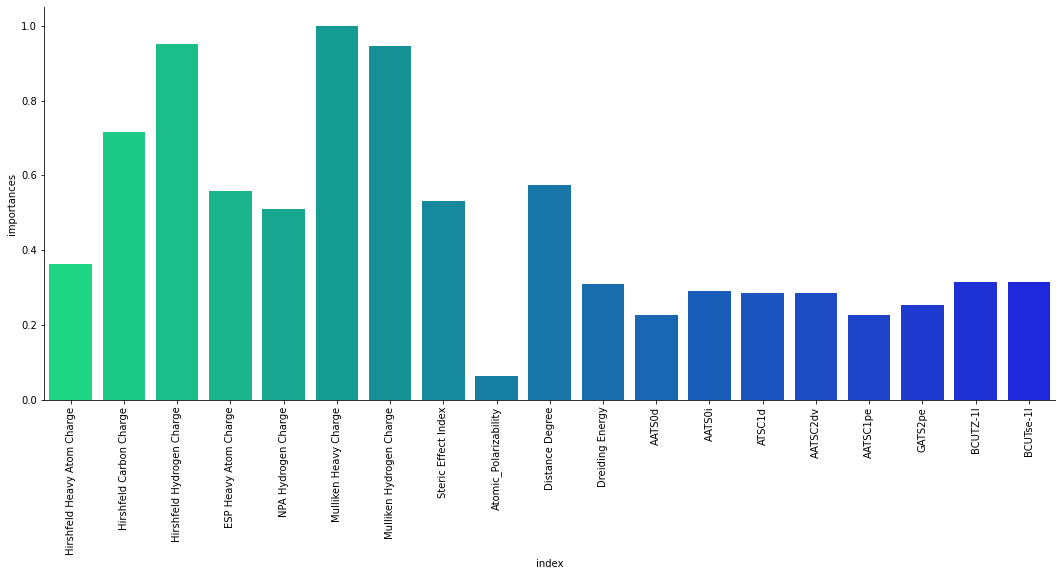

In [49]:
#Run the model with the highest accuracy chosen, allowing for a final feature selection

#Perform training/test set split
X_train, X_test, y_train, y_test = train_test_split(final, y, test_size=0.20, random_state=21)

#Apply over-sampling to dataset
ros = RandomOverSampler(random_state=10)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Applies random forest classifier to the dataset
rfc = RandomForestClassifier(n_estimators=800,max_depth=9)
rfc.fit(X_resampled, y_resampled)

trained_cluster_ids = hierarchy.fcluster(dist_linkage, 0.45, criterion="distance")
trained_cluster_id_to_feature_ids = defaultdict(list)

for idx, trained_cluster_id in enumerate(trained_cluster_ids):
    trained_cluster_id_to_feature_ids[trained_cluster_id].append(idx)
    
trained_selected_features = [v[0] for v in trained_cluster_id_to_feature_ids.values()]
final_selected_features = X_resampled.columns[trained_selected_features]

#Permutation plot with entire dataset, with the reduced features
X = final[final_selected_features]

rfc.fit(X, y)
correlated_trained_result = permutation_importance(
    rfc, X, y, n_repeats=5, random_state=16, n_jobs=5)

correlated_forest_importances = pd.Series(correlated_trained_result.importances_mean, 
                                          index= final_selected_features)

forest_plot_df = correlated_forest_importances.to_frame()
forest_plot_df.columns = ['importances']
forest_plot_df.reset_index(inplace=True)

forest_plot_df_scaled = forest_plot_df.copy()
forest_column = 'importances'
forest_plot_df_scaled[forest_column] = forest_plot_df_scaled[forest_column] /forest_plot_df_scaled[forest_column].abs().max()
forest_plot_df_scaled = forest_plot_df_scaled.set_index('index')
forest_plot_df_scaled['set']='full'
forest_plot_df_scaled.reset_index(inplace=True)

forest_drop_importances = forest_plot_df_scaled.index[forest_plot_df_scaled["importances"] == 0].tolist()
forest_plot_df_scaled_dropped = forest_plot_df_scaled.drop(forest_drop_importances, axis = 0)
full = forest_plot_df_scaled_dropped.copy()
ax = sns.catplot(x="index", y="importances", 

                data=forest_plot_df_scaled_dropped, kind="bar",

                height=6, palette="winter_r", aspect=15/6);

plt.xticks(rotation=90)
plt.show()

In [50]:
final_selected_features

Index(['Hirshfeld Heavy Atom Charge', 'Hirshfeld Carbon Charge',
       'Hirshfeld Hydrogen Charge', 'ESP Heavy Atom Charge',
       'NPA Hydrogen Charge', 'Mulliken Heavy Charge',
       'Mulliken Hydrogen Charge', 'Steric Effect Index',
       'Atomic_Polarizability', 'Distance Degree', 'Dreiding Energy', 'AATS0d',
       'AATS0i', 'ATSC1d', 'AATSC2dv', 'AATSC1pe', 'GATS2pe', 'BCUTZ-1l',
       'BCUTse-1l'],
      dtype='object')